## Lab 3

### Part 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.92 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и/или числа слоев и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

### Часть 1. Обучить сеть, которая покажет >= 0.92 test accuracy.

In [1]:
# Напишем свёрточную нейронную сеть с помощью PyTorch.

In [2]:
!nvidia-smi

Sat Feb 15 17:11:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX150       On   | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0    N/A /  N/A |   1013MiB /  2002MiB |     28%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets
from torchvision import transforms

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [5]:
#также будем использовать аугментацию: рандомные повороты на 7 градусов и отражение относительно вертикали.

#преобразование трейна
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(7),
    transforms.ToTensor()
])

#тест не меняем
test_tf = transforms.Compose([
    transforms.ToTensor()
])

train = torchvision.datasets.CIFAR10('./', download=True, train=True, transform=train_tf)
test = torchvision.datasets.CIFAR10('./', download=True, train=False, transform=test_tf)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
#трейновая выборка
trainloader = torch.utils.data.DataLoader(dataset=train, batch_size=64)

#тестовая выборка
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=256, shuffle=False)

In [10]:
#напишем нашу свёрточную нейронную сеть. 4 сверточных слоя 3x3 с maxpool и батч-норм.
#также три полносвязанных слоя, с дропаутом после каждого
#в целом, попытался регулиризовать нейронку с помощью аугментации, батч-норм и дропаута

class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.act1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.act2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.act3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=64)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.act4 = torch.nn.LeakyReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=128)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=3, stride=3)

        self.fc1 = torch.nn.Linear(128, 80)
        self.act5 = torch.nn.LeakyReLU()
        self.dropout1 = torch.nn.Dropout(0.5)

        self.fc2 = torch.nn.Linear(80, 80)
        self.act6 = torch.nn.LeakyReLU()
        self.dropout2 = torch.nn.Dropout(0.5)

        self.fc3 = torch.nn.Linear(80, 80)
        self.act7 = torch.nn.Tanh()
        self.dropout3 = torch.nn.Dropout(0.5)     

        self.fc4 = torch.nn.Linear(80, 10)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.act4(x)
        x = self.bn4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act5(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.act6(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.act7(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        
        return x

In [11]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
print(device)

cuda:0


In [13]:
net = MyNet()

#не забудем положить её на куду
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [14]:
#В качестве лоса возмем кросс-энтропию. Оптимизатор - Адам
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

#добавим уменьшение лернинг рейта, если выходим на плато. Это решение будем принимать по валидационной выборке.
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=7, factor=0.2)

In [15]:
def train(epoch):
    running_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
    len_train = 0.0
    len_test = 0.0
    
    loss_train = 0.0
  
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss_val = loss(outputs, targets)
        loss_val.backward()
        optimizer.step()
        accuracy_add = (outputs.argmax(dim=1) == targets).float().sum().data.cpu()
        train_acc += accuracy_add #не забываем считать метрику на тесте
        len_train += len(targets)
        loss_train += len(targets) * loss_val.item()
        running_loss += loss_val.item()
        
    for _, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        accuracy_add = (outputs.argmax(dim=1) == targets).float().sum().data.cpu()
        test_acc += accuracy_add #не забываем считать метрику на тесте
        len_test += len(targets)
        
    lr_scheduler.step(running_loss)

    return train_acc / len_train, test_acc / len_test

In [16]:
#обучим нашу нейронную сеть, думаю, в районе 50-70 эпох будет достаточно. 
#Будем выводить на каждой эпохе accuracy на трейновой, валидационной и тестовой выборках

accuracy_history_test = []
accuracy_history_train = []

for epoch in range(0, 80):
    train_acc, test_acc = train(epoch)
    accuracy_history_test.append(test_acc)
    accuracy_history_train.append(train_acc)    
    print('Epoch:', epoch, '   acc_train:', np.round(train_acc.numpy(), 4), '   test_acc:', np.round(test_acc.numpy(), 4))

Epoch: 0    acc_train: 0.3513    test_acc: 0.4614
Epoch: 1    acc_train: 0.5091    test_acc: 0.5514
Epoch: 2    acc_train: 0.5805    test_acc: 0.5793
Epoch: 3    acc_train: 0.6183    test_acc: 0.6261
Epoch: 4    acc_train: 0.639    test_acc: 0.6542
Epoch: 5    acc_train: 0.6623    test_acc: 0.6709
Epoch: 6    acc_train: 0.6792    test_acc: 0.6746
Epoch: 7    acc_train: 0.6891    test_acc: 0.6825
Epoch: 8    acc_train: 0.7015    test_acc: 0.6971
Epoch: 9    acc_train: 0.7115    test_acc: 0.7061
Epoch: 10    acc_train: 0.7222    test_acc: 0.712
Epoch: 11    acc_train: 0.7286    test_acc: 0.7162
Epoch: 12    acc_train: 0.7316    test_acc: 0.7234
Epoch: 13    acc_train: 0.7391    test_acc: 0.7259
Epoch: 14    acc_train: 0.7446    test_acc: 0.7266
Epoch: 15    acc_train: 0.7507    test_acc: 0.7324
Epoch: 16    acc_train: 0.7541    test_acc: 0.7361
Epoch: 17    acc_train: 0.7603    test_acc: 0.7367
Epoch: 18    acc_train: 0.7641    test_acc: 0.733
Epoch: 19    acc_train: 0.7646    test_acc: 

Text(0, 0.5, 'Accuracy')

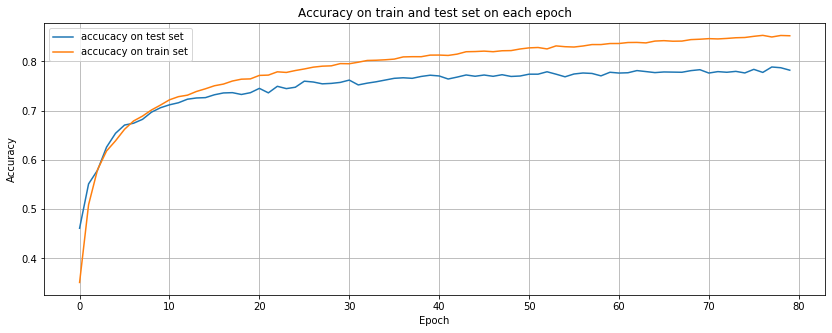

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[14, 5])
plt.plot(accuracy_history_test, label='accucacy on test set')
plt.plot(accuracy_history_train, label='accucacy on train set')
plt.legend(loc='best')
plt.title('Accuracy on train and test set on each epoch')
plt.grid('True')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [18]:
net = net.eval()

In [19]:
torch.save(net, 'CIFAR10_net.pth')

/home/matvey/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MyNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
quit()